# Практическая работа №3

### Гопиенко Александр Дмитриевич КИ22-17/2Б

In [25]:
import os
import glob
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F

### 1) Считываем данные

In [15]:
data_dir = "PH2 Dataset images"
selected_dirs = [d for d in os.listdir(data_dir) if d.startswith("IMD")] 

image_paths = []
mask_paths = []

for dir_name in selected_dirs:
    dir_path = os.path.join(data_dir, dir_name)
    sub_dirs = os.listdir(dir_path)  

    derm_path = os.path.join(dir_path, f"{dir_name}_Dermoscopic_Image")
    lesion_path = os.path.join(dir_path, f"{dir_name}_lesion")

    if os.path.exists(derm_path) and os.path.exists(lesion_path):
        image_paths.extend(sorted(glob.glob(os.path.join(derm_path, "*.bmp"))))
        mask_paths.extend(sorted(glob.glob(os.path.join(lesion_path, "*.bmp"))))

print(f"Найдено {len(image_paths)} изображений и {len(mask_paths)} масок.")

Найдено 200 изображений и 200 масок.


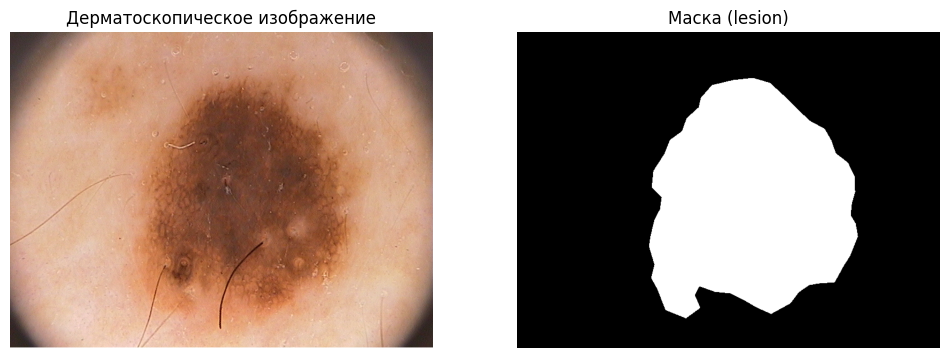

In [17]:
image = cv2.imread(image_paths[0])  
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
mask = cv2.imread(mask_paths[0], cv2.IMREAD_GRAYSCALE)  

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Дерматоскопическое изображение")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray")
plt.title("Маска (lesion)")
plt.axis("off")

plt.show()


### 2) Создание датасета

In [21]:
IMG_SIZE = (256, 256)

def load_data(image_paths, mask_paths):
    images, masks = [], []
    for img_path, mask_path in tqdm(zip(image_paths, mask_paths), total=len(image_paths)):
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMG_SIZE)
        img = img / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, IMG_SIZE)
        mask = mask / 255.0

        images.append(img.transpose(2, 0, 1))
        masks.append(mask[np.newaxis, :, :])

    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)

X, y = load_data(image_paths=image_paths, mask_paths=mask_paths)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Размер тренировочной выборки: {len(X_train)}")
print(f"Размер валидационной выборки: {len(X_val)}")
print(f"Размер тестовой выборки: {len(X_test)}")

100%|██████████| 200/200 [00:08<00:00, 24.14it/s]


Размер тренировочной выборки: 120
Размер валидационной выборки: 40
Размер тестовой выборки: 40


In [24]:
class PH2Dataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return torch.tensor(self.images[idx], dtype=torch.float32), torch.tensor(self.masks[idx], dtype=torch.float32)
    
train_dataset = PH2Dataset(X_train, y_train)
val_dataset = PH2Dataset(X_val, y_val)
test_dataset = PH2Dataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### 3) Модель №1

In [ ]:
class SimpleSegNet(nn.Module):
  def __init__(self, num_classes):
    super(SimpleSegNet, self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2),
    )

    self.bottleneck = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(64, num_classes, kernel_size=2, stride=2),
    )

  def forward(self, x):

    x = self.encoder(x)

    x = self.bottleneck(x)

    x = self.decoder(x)

    return x

### Модель №2

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        self.conv1 = self.double_conv(in_channels, 64)
        self.conv2 = self.double_conv(64, 128)
        self.conv3 = self.double_conv(128, 256)
        self.conv4 = self.double_conv(256, 512)

        self.bottleneck = self.double_conv(512, 1024)

        self.upconv4 = self.upconv(1024, 512)
        self.conv4d = self.double_conv(1024, 512)

        self.upconv3 = self.upconv(512, 256)
        self.conv3d = self.double_conv(512, 256)

        self.upconv2 = self.upconv(256, 128)
        self.conv2d = self.double_conv(256, 128)

        self.upconv1 = self.upconv(128, 64)
        self.conv1d = self.double_conv(128, 64)

        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def upconv(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        enc1 = self.conv1(x)
        enc2 = self.conv2(F.max_pool2d(enc1, 2))
        enc3 = self.conv3(F.max_pool2d(enc2, 2))
        enc4 = self.conv4(F.max_pool2d(enc3, 2))

        bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

        up4 = self.upconv4(bottleneck)
        up4 = torch.cat([up4, enc4], dim=1)  
        dec4 = self.conv4d(up4)

        up3 = self.upconv3(dec4)
        up3 = torch.cat([up3, enc3], dim=1)
        dec3 = self.conv3d(up3)

        up2 = self.upconv2(dec3)
        up2 = torch.cat([up2, enc2], dim=1)
        dec2 = self.conv2d(up2)

        up1 = self.upconv1(dec2)
        up1 = torch.cat([up1, enc1], dim=1)
        dec1 = self.conv1d(up1)

        return self.final_conv(dec1)

### Модель №3